In [2]:
# Feature Engineering for Manipulation Detection
import numpy as np
import pandas as pd

# Calculate rolling statistics for anomaly detection
window_size = 60  # 60 minutes (1 hour) rolling window

preprocessed_data = pd.read_csv('preprocessed_data.csv')
# Volume features
preprocessed_data['volume_rolling_mean'] = preprocessed_data['msg_volume'].rolling(window=window_size, min_periods=1).mean()
preprocessed_data['volume_rolling_std'] = preprocessed_data['msg_volume'].rolling(window=window_size, min_periods=1).std()
preprocessed_data['volume_zscore'] = (preprocessed_data['msg_volume'] - preprocessed_data['volume_rolling_mean']) / (preprocessed_data['volume_rolling_std'] + 1e-6)

# Sentiment features
preprocessed_data['sentiment_rolling_mean'] = preprocessed_data['avg_sentiment'].rolling(window=window_size, min_periods=1).mean()
preprocessed_data['sentiment_rolling_std'] = preprocessed_data['avg_sentiment'].rolling(window=window_size, min_periods=1).std()
preprocessed_data['sentiment_zscore'] = (preprocessed_data['avg_sentiment'] - preprocessed_data['sentiment_rolling_mean']) / (preprocessed_data['sentiment_rolling_std'] + 1e-6)

# Price volatility
preprocessed_data['price_change_abs'] = preprocessed_data['price_change'].abs()
preprocessed_data['price_volatility'] = preprocessed_data['price_change_abs'].rolling(window=window_size, min_periods=1).mean()

# Volume spike indicator (binary)
preprocessed_data['volume_spike'] = (preprocessed_data['volume_zscore'] > 2).astype(int)

# Sentiment spike indicator (binary)
preprocessed_data['sentiment_spike'] = (preprocessed_data['sentiment_zscore'] > 2).astype(int)

# Combined manipulation signal (both volume and sentiment spike)
preprocessed_data['manipulation_signal'] = ((preprocessed_data['volume_spike'] == 1) & 
                                           (preprocessed_data['sentiment_spike'] == 1)).astype(int)

preprocessed_data.head(10)


,minute,msg_volume,avg_sentiment,close_price,price_change,volume_rolling_mean,volume_rolling_std,volume_zscore,sentiment_rolling_mean,sentiment_rolling_std,sentiment_zscore,price_change_abs,price_volatility,volume_spike,sentiment_spike,manipulation_signal
0,2018-03-23 00:40:00,33,0.575758,8719.43,11.13,33.000000,NaN,NaN,0.575758,NaN,NaN,11.13,11.130000,0,0,0
1,2018-03-23 00:41:00,95,0.284211,8701.82,-17.61,64.000000,43.840620,0.707107,0.429984,0.206155,-0.707103,17.61,14.370000,0,0,0
2,2018-03-23 00:42:00,114,0.368421,8703.53,1.71,80.666667,42.359572,0.786914,0.409463,0.150044,-0.273531,1.71,10.150000,0,0,0
3,2018-03-23 00:43:00,106,0.358491,8703.51,-0.02,87.000000,36.832956,0.515842,0.396720,0.125133,-0.305506,0.02,7.617500,0,0,0
4,2018-03-23 00:44:00,93,0.387097,8703.51,0.00,88.200000,32.010936,0.149949,0.394795,0.108454,-0.070983,0.00,6.094000,0,0,0
5,2018-03-23 00:45:00,111,0.333333,8706.52,3.01,92.000000,30.106478,0.631093,0.384552,0.100197,-0.511171,3.01,5.580000,0,0,0
6,2018-03-23 00:46:00,99,0.202020,8695.00,-11.52,93.000000,27.610385,0.217310,0.358476,0.114568,-1.365598,11.52,6.428571,0,0,0
7,2018-03-23 00:47:00,113,0.327434,8687.90,-7.10,95.500000,26.522228,0.659824,0.354595,0.106636,-0.254713,7.10,6.512500,0,0,0
8,2018-03-23 00:48:00,78,0.397436,8682.30,-5.60,93.555556,25.485835,-0.610361,0.359356,0.100766,0.377907,5.60,6.411111,0,0,0
9,2018-03-23 00:49:00,68,0.514706,8689.10,6.80,91.000000,25.350871,-0.907267,0.374891,0.106953,1.307249,6.80,6.450000,0,0,0


In [3]:
# Z-Score Based Anomaly Detection
# Calculate signal strength based on Z-scores

def calculate_signal_strength(volume_zscore, sentiment_zscore, price_volatility):
    """
    Calculate manipulation signal strength (0-100 scale)
    Higher values indicate stronger manipulation signals
    """
    # Base signal from volume anomaly
    volume_signal = min(50, max(0, volume_zscore * 10))
    
    # Base signal from sentiment anomaly
    sentiment_signal = min(50, max(0, sentiment_zscore * 10))
    
    # Combined signal (both anomalies present = stronger signal)
    if volume_zscore > 2 and sentiment_zscore > 2:
        combined_signal = volume_signal + sentiment_signal
    else:
        combined_signal = (volume_signal + sentiment_signal) / 2
    
    # Adjust for price volatility (higher volatility = stronger signal)
    volatility_multiplier = min(1.5, 1 + (price_volatility / 100))
    
    signal_strength = min(100, combined_signal * volatility_multiplier)
    return signal_strength

preprocessed_data['signal_strength'] = preprocessed_data.apply(
    lambda row: calculate_signal_strength(
        row['volume_zscore'], 
        row['sentiment_zscore'],
        row['price_volatility'] if not pd.isna(row['price_volatility']) else 0
    ), axis=1
)

# Display top manipulation signals
top_signals = preprocessed_data.nlargest(20, 'signal_strength')[
    ['minute', 'msg_volume', 'avg_sentiment', 'close_price', 'price_change', 
     'volume_zscore', 'sentiment_zscore', 'signal_strength', 'manipulation_signal']
]
print("Top 20 Manipulation Signals (by Signal Strength):")
top_signals


Top 20 Manipulation Signals (by Signal Strength):


,minute,msg_volume,avg_sentiment,close_price,price_change,volume_zscore,sentiment_zscore,signal_strength,manipulation_signal
380,2018-03-23 07:00:00,354,0.155367,8379.00,2.53,6.580390,-2.566411,27.092833,0
381,2018-03-23 07:01:00,414,0.183575,8386.99,7.99,5.516417,-2.204820,27.088625,0
80,2018-03-23 02:00:00,191,0.172775,8598.67,14.50,5.162474,-1.914027,26.915708,0
290,2018-03-23 05:30:00,249,0.212851,8388.11,6.14,5.385241,-1.498203,26.708708,0
260,2018-03-23 05:00:00,185,0.183784,8402.70,-14.16,4.865247,-1.737794,25.965257,0
140,2018-03-23 03:00:00,198,0.237374,8428.43,0.44,4.542229,-1.055189,25.192491,0
200,2018-03-23 04:00:00,178,0.185393,8417.64,-1.18,4.411726,-1.767705,23.478284,0
350,2018-03-23 06:30:00,172,0.186047,8415.98,-1.02,3.831057,-1.552958,20.547907,0
170,2018-03-23 03:30:00,169,0.106509,8424.02,10.21,3.348148,-2.577350,18.073498,0
20,2018-03-23 01:00:00,176,0.176136,8635.42,-14.58,3.154728,-1.745818,16.944196,0


In [4]:
# Isolation Forest for Anomaly Detection
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Prepare features for Isolation Forest
features_for_detection = ['msg_volume', 'avg_sentiment', 'price_change_abs', 
                          'volume_zscore', 'sentiment_zscore', 'price_volatility']
feature_data = preprocessed_data[features_for_detection].fillna(0)

# Standardize features
scaler = StandardScaler()
feature_data_scaled = scaler.fit_transform(feature_data)

# Apply Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
preprocessed_data['isolation_anomaly'] = isolation_forest.fit_predict(feature_data_scaled)
preprocessed_data['isolation_anomaly'] = (preprocessed_data['isolation_anomaly'] == -1).astype(int)

# Combine Z-score and Isolation Forest signals
preprocessed_data['combined_manipulation_signal'] = (
    (preprocessed_data['manipulation_signal'] == 1) | 
    (preprocessed_data['isolation_anomaly'] == 1)
).astype(int)

print(f"Z-score based signals: {preprocessed_data['manipulation_signal'].sum()}")
print(f"Isolation Forest anomalies: {preprocessed_data['isolation_anomaly'].sum()}")
print(f"Combined signals: {preprocessed_data['combined_manipulation_signal'].sum()}")


Z-score based signals: 0
Isolation Forest anomalies: 50
Combined signals: 50


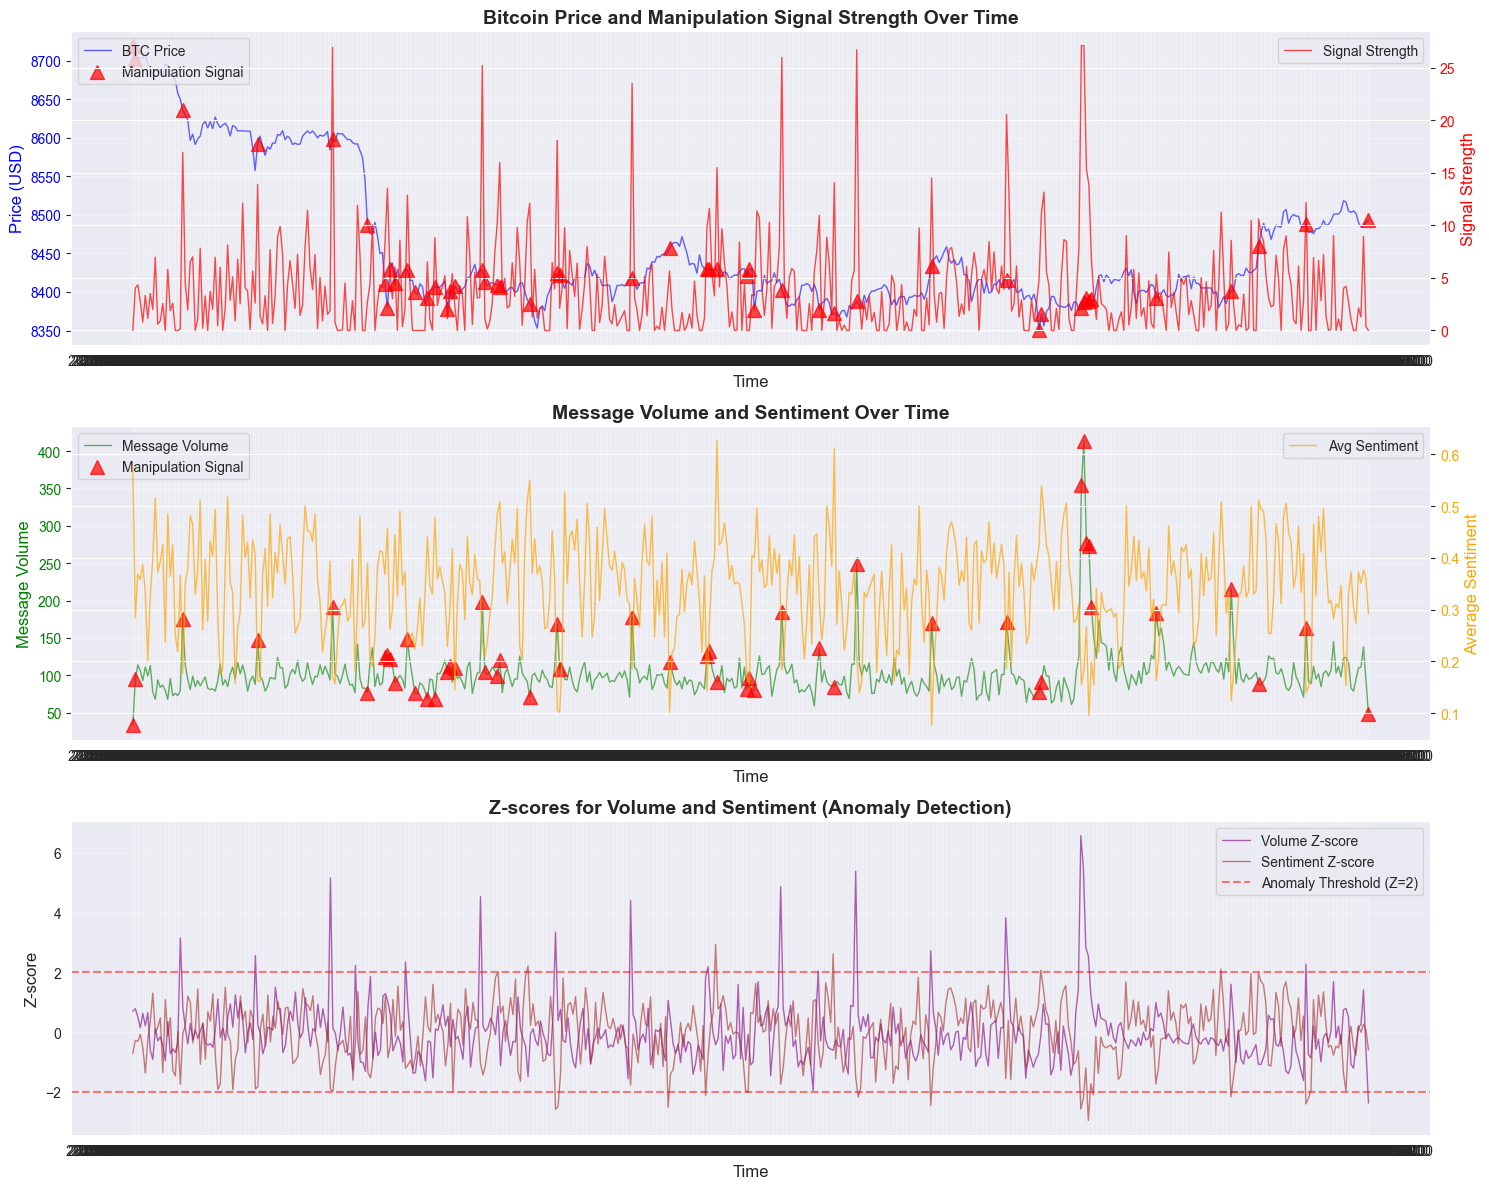


Dashboard saved as 'manipulation_detection_dashboard.png'


In [5]:
# Visualization Dashboard
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Filter data for visualization (remove NaN values)
viz_data = preprocessed_data.dropna(subset=['price_change', 'signal_strength'])

# Create subplots - 3 plots
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Price and Signal Strength over time
ax1 = axes[0]
ax1_twin = ax1.twinx()

# Plot price
ax1.plot(viz_data['minute'], viz_data['close_price'], 'b-', alpha=0.6, label='BTC Price', linewidth=1)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Price (USD)', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')

# Plot signal strength
ax1_twin.plot(viz_data['minute'], viz_data['signal_strength'], 'r-', alpha=0.7, label='Signal Strength', linewidth=1)
ax1_twin.set_ylabel('Signal Strength', color='r', fontsize=12)
ax1_twin.tick_params(axis='y', labelcolor='r')

# Highlight manipulation signals
manipulation_points = viz_data[viz_data['combined_manipulation_signal'] == 1]
ax1.scatter(manipulation_points['minute'], manipulation_points['close_price'], 
           c='red', s=100, alpha=0.7, marker='^', label='Manipulation Signal', zorder=5)

ax1.set_title('Bitcoin Price and Manipulation Signal Strength Over Time', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Volume and Sentiment
ax2 = axes[1]
ax2_twin = ax2.twinx()

ax2.plot(viz_data['minute'], viz_data['msg_volume'], 'g-', alpha=0.6, label='Message Volume', linewidth=1)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Message Volume', color='g', fontsize=12)
ax2.tick_params(axis='y', labelcolor='g')

ax2_twin.plot(viz_data['minute'], viz_data['avg_sentiment'], 'orange', alpha=0.7, label='Avg Sentiment', linewidth=1)
ax2_twin.set_ylabel('Average Sentiment', color='orange', fontsize=12)
ax2_twin.tick_params(axis='y', labelcolor='orange')

# Highlight manipulation signals
ax2.scatter(manipulation_points['minute'], manipulation_points['msg_volume'], 
           c='red', s=100, alpha=0.7, marker='^', label='Manipulation Signal', zorder=5)

ax2.set_title('Message Volume and Sentiment Over Time', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Z-scores
ax3 = axes[2]
ax3.plot(viz_data['minute'], viz_data['volume_zscore'], 'purple', alpha=0.6, label='Volume Z-score', linewidth=1)
ax3.plot(viz_data['minute'], viz_data['sentiment_zscore'], 'brown', alpha=0.6, label='Sentiment Z-score', linewidth=1)
ax3.axhline(y=2, color='r', linestyle='--', alpha=0.5, label='Anomaly Threshold (Z=2)')
ax3.axhline(y=-2, color='r', linestyle='--', alpha=0.5)
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('Z-score', fontsize=12)
ax3.set_title('Z-scores for Volume and Sentiment (Anomaly Detection)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('manipulation_detection_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nDashboard saved as 'manipulation_detection_dashboard.png'")


In [6]:
# Summary Statistics and Evaluation
print("=" * 80)
print("MANIPULATION DETECTION SUMMARY")
print("=" * 80)

total_minutes = len(preprocessed_data)
manipulation_events = preprocessed_data['combined_manipulation_signal'].sum()
manipulation_rate = (manipulation_events / total_minutes) * 100

print(f"\nTotal time periods analyzed: {total_minutes:,} minutes")
print(f"Manipulation signals detected: {manipulation_events:,} ({manipulation_rate:.2f}%)")

# Correlation analysis
correlation_data = preprocessed_data[['signal_strength', 'price_change_abs', 'msg_volume', 'avg_sentiment']].corr()
print("\n" + "=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)
print(correlation_data)

# Top manipulation events
print("\n" + "=" * 80)
print("TOP 10 MANIPULATION EVENTS (by Signal Strength)")
print("=" * 80)
top_events = preprocessed_data.nlargest(10, 'signal_strength')[
    ['minute', 'msg_volume', 'avg_sentiment', 'close_price', 'price_change', 
     'volume_zscore', 'sentiment_zscore', 'signal_strength']
]
print(top_events.to_string())

# Save final results
preprocessed_data.to_csv('manipulation_detection_results.csv', index=False)
print(f"\nResults saved to 'manipulation_detection_results.csv'")


MANIPULATION DETECTION SUMMARY

Total time periods analyzed: 496 minutes
Manipulation signals detected: 50 (10.08%)

CORRELATION ANALYSIS
                  signal_strength  price_change_abs  msg_volume  avg_sentiment
signal_strength          1.000000          0.047416    0.600655       0.178497
price_change_abs         0.047416          1.000000   -0.031183       0.020256
msg_volume               0.600655         -0.031183    1.000000      -0.390677
avg_sentiment            0.178497          0.020256   -0.390677       1.000000

TOP 10 MANIPULATION EVENTS (by Signal Strength)
                  minute  msg_volume  avg_sentiment  close_price  price_change  volume_zscore  sentiment_zscore  signal_strength
380  2018-03-23 07:00:00         354       0.155367      8379.00          2.53       6.580390         -2.566411        27.092833
381  2018-03-23 07:01:00         414       0.183575      8386.99          7.99       5.516417         -2.204820        27.088625
80   2018-03-23 02:00:00       

Saved 50 detected manipulation events to 'detected_manipulation_events.csv'


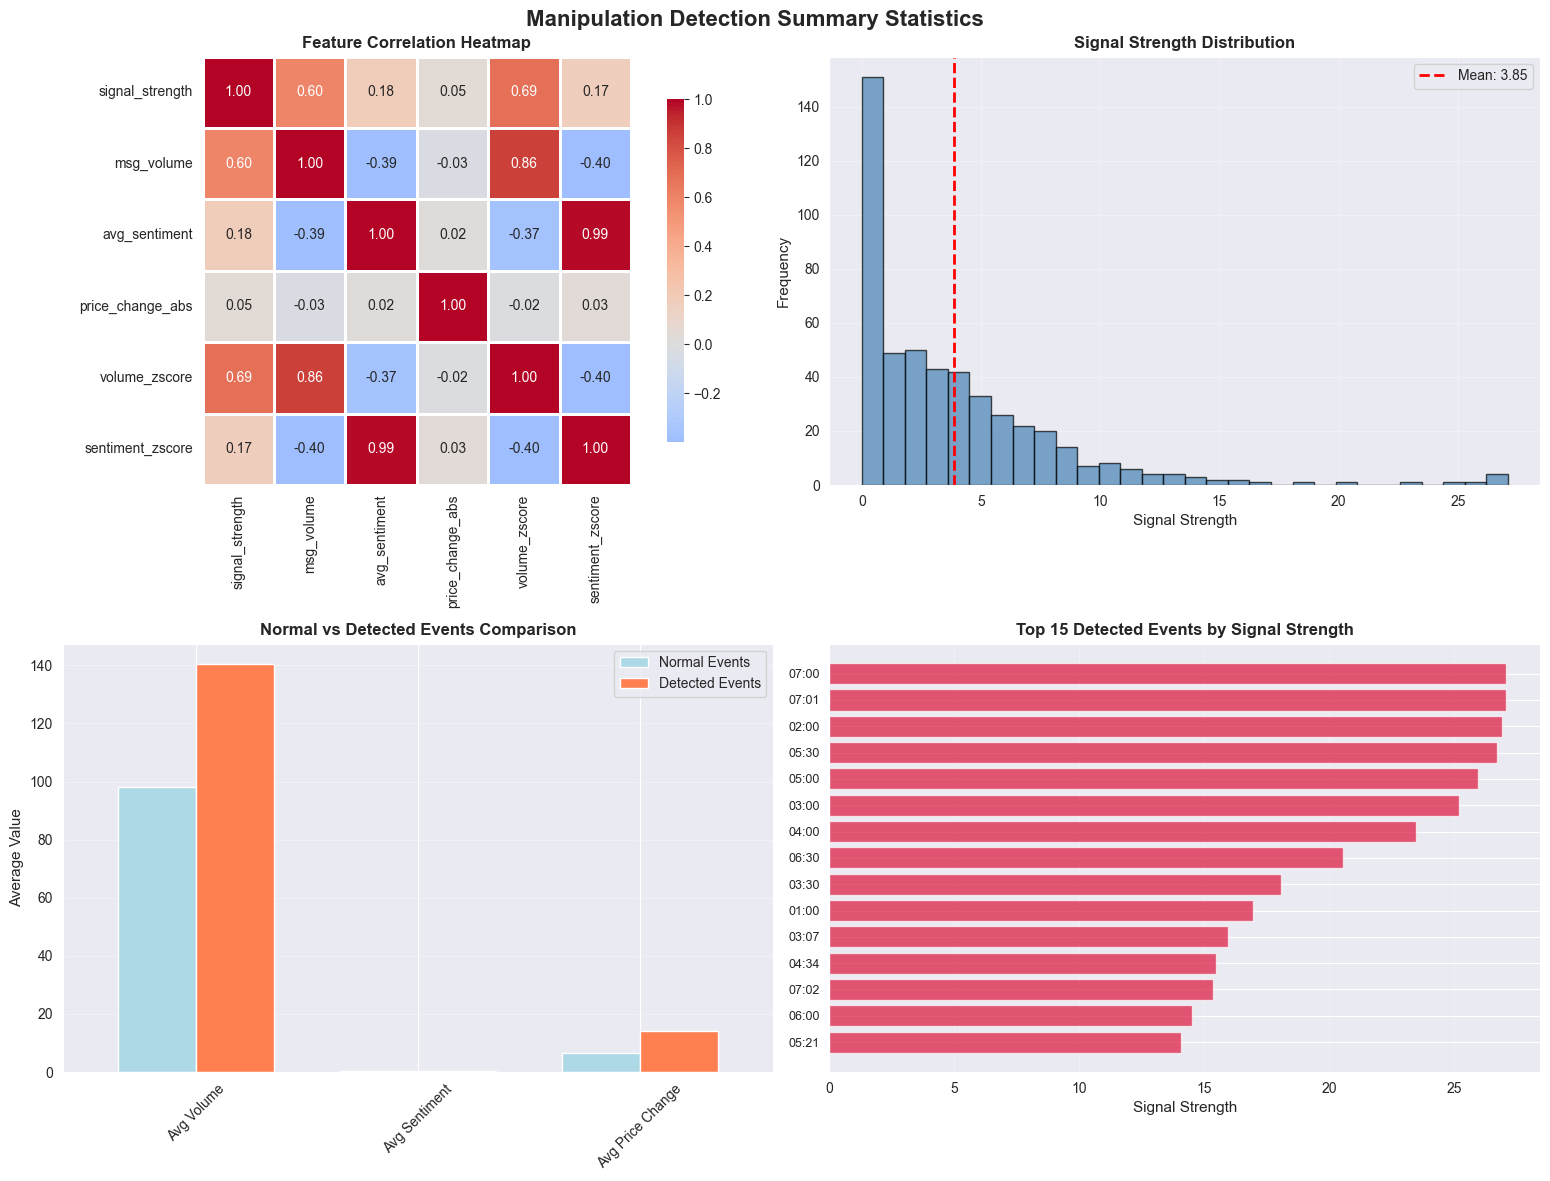


Summary statistics visualization saved as 'manipulation_summary_statistics.png'

Total detected events: 50
Average signal strength of detected events: 10.84
Max signal strength: 27.09


In [7]:
# Save Detected Manipulation Events and Create Summary Statistics Visualization

# Filter and save only detected manipulation events
detected_events = preprocessed_data[preprocessed_data['combined_manipulation_signal'] == 1].copy()
detected_events = detected_events.sort_values('signal_strength', ascending=False)

# Save detected events to CSV
detected_events.to_csv('detected_manipulation_events.csv', index=False)
print(f"Saved {len(detected_events)} detected manipulation events to 'detected_manipulation_events.csv'")

# Create Summary Statistics Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Manipulation Detection Summary Statistics', fontsize=16, fontweight='bold')

# Plot 1: Correlation Heatmap
ax1 = axes[0, 0]
correlation_features = ['signal_strength', 'msg_volume', 'avg_sentiment', 'price_change_abs', 
                         'volume_zscore', 'sentiment_zscore']
corr_matrix = preprocessed_data[correlation_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax1)
ax1.set_title('Feature Correlation Heatmap', fontsize=12, fontweight='bold')

# Plot 2: Signal Strength Distribution
ax2 = axes[0, 1]
ax2.hist(preprocessed_data['signal_strength'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(preprocessed_data['signal_strength'].mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {preprocessed_data["signal_strength"].mean():.2f}')
ax2.set_xlabel('Signal Strength', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Signal Strength Distribution', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Detected vs Normal Events Comparison
ax3 = axes[1, 0]
normal_events = preprocessed_data[preprocessed_data['combined_manipulation_signal'] == 0]
comparison_data = pd.DataFrame({
    'Normal Events': [normal_events['msg_volume'].mean(), normal_events['avg_sentiment'].mean(), 
                     normal_events['price_change_abs'].mean()],
    'Detected Events': [detected_events['msg_volume'].mean(), detected_events['avg_sentiment'].mean(), 
                       detected_events['price_change_abs'].mean()]
}, index=['Avg Volume', 'Avg Sentiment', 'Avg Price Change'])
comparison_data.plot(kind='bar', ax=ax3, color=['lightblue', 'coral'], width=0.7)
ax3.set_ylabel('Average Value', fontsize=11)
ax3.set_title('Normal vs Detected Events Comparison', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Top 15 Detected Events by Signal Strength
ax4 = axes[1, 1]
top_15 = detected_events.nlargest(15, 'signal_strength')
ax4.barh(range(len(top_15)), top_15['signal_strength'], color='crimson', alpha=0.7)
ax4.set_yticks(range(len(top_15)))
ax4.set_yticklabels([pd.to_datetime(str(t)).strftime('%H:%M') for t in top_15['minute']], fontsize=9)
ax4.set_xlabel('Signal Strength', fontsize=11)
ax4.set_title('Top 15 Detected Events by Signal Strength', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.invert_yaxis()

plt.tight_layout()
plt.savefig('manipulation_summary_statistics.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSummary statistics visualization saved as 'manipulation_summary_statistics.png'")
print(f"\nTotal detected events: {len(detected_events)}")
print(f"Average signal strength of detected events: {detected_events['signal_strength'].mean():.2f}")
print(f"Max signal strength: {detected_events['signal_strength'].max():.2f}")

